In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from scipy.special import expit
import torch
from torch import nn, optim
import torch.nn.functional as F
from datasets.datasets import get_wine_dataloader, get_iris_dataloader, get_australian_dataloader, get_10x_73k_dataloader
from sklearn.manifold import TSNE
#TODO Cuda
device = torch.device("cpu")

## Wine

In [2]:
n_clusters = 3
batch_size = 89
dataloader, data_shape = get_wine_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 10
h2 = 30
latent_dim = 5

## Iris

In [2]:
n_clusters = 3
batch_size = 50
dataloader, data_shape = get_iris_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 3
h2 = 15
latent_dim = 2

## Australian

In [2]:
n_clusters = 2
batch_size = 69
dataloader, data_shape = get_australian_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 10
h2 = 30
latent_dim = 3

## 10x_73k

In [2]:
n_clusters = 8
batch_size = 256
dataloader, data_shape = get_10x_73k_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 500
h2 = 1500
latent_dim = 10

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, n_features):
        super(Autoencoder, self).__init__()
        # Encoder Model
        self.encoder_model = nn.Sequential(
            nn.Linear(data_shape, h1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h1),
            
            nn.Linear(h1, h2, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h2),
            
            nn.Linear(h2, latent_dim, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(latent_dim),
            
            #nn.Linear(h3, h4, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(h4),
        )
        
        # Clustering MLP
        self.cluster_MLP = nn.Sequential(
            #nn.Linear(latent_dim, h1, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(h1),
            
            nn.Linear(latent_dim, n_clusters, bias=True),
            nn.BatchNorm1d(n_clusters)
        )
        
        # Decoder Model
        self.decoder_model = nn.Sequential(
            #nn.Linear(h4, h3, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(h3),
            
            nn.Linear(latent_dim, h2, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h2),
            
            nn.Linear(h2, h1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h1),
            
            nn.Linear(h1, data_shape, bias=True),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.encoder_model(x)
        x = self.decoder_model(x)
        return x

    def forward_softMin(self, x):
        x = self.encoder_model(x)
        x = self.cluster_MLP(x)
        x = F.softmin(x, dim=1)
        return x
    
    def encoder(self, x):
        x = self.encoder_model(x)
        return x
    
    def decoder(self, x):
        x = self.decoder_model(x)
        return x

autoencoder = Autoencoder(100)
autoencoder = autoencoder.to(device)

In [4]:
def soft_silhouette(X, soft_clustering, requires_distance_grad=False):
    # No grads at distances
    if requires_distance_grad: X = X.detach()
    distances = torch.cdist(X, X, p=2)
    alphas = torch.matmul(distances, soft_clustering)
    n_data, n_clusters = alphas.shape
    betas = torch.empty(alphas.shape)
    
    for i in range(n_data):
        for j in range(n_clusters):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    
    # Calculate soft silhouette
    sc = torch.div(torch.sub(betas, alphas), torch.max(alphas, betas))
    s = torch.mean(torch.sum(torch.mul(soft_clustering, sc), dim=1))

    return s

def transform_clusters_to_labels(clusters, labels):
    # Get the data clusters based on max neuron
    clusters = torch.argmax(clusters, dim=1)
    clusters = clusters.cpu().detach().numpy()

    # Find the cluster ids (labels)
    c_ids = np.unique(clusters)
    labels = labels.cpu().data.numpy()

    # Dictionary to transform cluster label to real label
    dict_clusters_to_labels = dict()
    
    # For every cluster find the most frequent data label
    for c_id in c_ids:
        indexes_of_cluster_i = np.where(c_id == clusters)
        elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
        true_label_index = np.argmax(frequency)
        true_label = elements[true_label_index]
        dict_clusters_to_labels[c_id] = true_label

    # Change the cluster labels to real labels
    for i, element in enumerate(clusters):
        clusters[i] = dict_clusters_to_labels[element]

    return clusters

In [ ]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
mse = nn.MSELoss()

for epoch in range(1000):
    for batch_index, (real_data, labels) in enumerate(dataloader):
        reconstruction = autoencoder.forward(real_data)
        loss = mse(real_data, reconstruction)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: {} Rec: {:.4f} ".format(epoch, loss))

Epoch: 0 Rec: 0.0110 


In [6]:
lamda = 100
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
mse = nn.MSELoss()

latent_data = np.zeros((N, latent_dim))
real_labels = np.zeros((N), dtype=np.int32)
predicted_labels = np.zeros((N), dtype=np.int32)

for epoch in range(200):
    sum_rec_loss = 0
    sum_soft_sihouette = 0
    for batch_index, (real_data, labels) in enumerate(dataloader):
        reconstruction = autoencoder.forward(real_data)
        soft_clustering = autoencoder.forward_softMin(real_data)
        code = autoencoder.encoder(real_data)
        s = soft_silhouette(code, soft_clustering, requires_distance_grad=True)
        rec = mse(reconstruction, real_data)
        loss = 1 - s + lamda * rec
        
        sum_rec_loss += rec.item()
        sum_soft_sihouette += s.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Selecting the nearest samples and save their priors
        lower = batch_index * batch_size
        upper = (batch_index + 1) * batch_size
        latent_data[lower:upper] = code.cpu().detach().numpy()
        real_labels[lower:upper] = labels.cpu().data.numpy()
        predicted_labels[lower:upper] = transform_clusters_to_labels(soft_clustering, labels)
    
    accuracy = accuracy_score(real_labels, predicted_labels)
    nmi = normalized_mutual_info_score(real_labels, predicted_labels)
    total_loss = sum_rec_loss + sum_soft_sihouette
    print("Epoch: {} L: {:.4f} Rec: {:.4f} Soft SIL: {:.2f} ACC: {:.2f} NMI: {:.2f} ".format(epoch, total_loss, sum_rec_loss, sum_soft_sihouette, accuracy, nmi))

Epoch: 0 L: 1.5488 Rec: 0.1177 Soft SIL: 1.43 ACC: 0.61 NMI: 0.03 
Epoch: 1 L: 2.1550 Rec: 0.1101 Soft SIL: 2.04 ACC: 0.70 NMI: 0.11 
Epoch: 2 L: 2.5981 Rec: 0.1052 Soft SIL: 2.49 ACC: 0.72 NMI: 0.14 
Epoch: 3 L: 2.9983 Rec: 0.1041 Soft SIL: 2.89 ACC: 0.73 NMI: 0.16 
Epoch: 4 L: 3.2316 Rec: 0.1039 Soft SIL: 3.13 ACC: 0.75 NMI: 0.18 
Epoch: 5 L: 3.3622 Rec: 0.1046 Soft SIL: 3.26 ACC: 0.76 NMI: 0.20 
Epoch: 6 L: 3.4498 Rec: 0.1031 Soft SIL: 3.35 ACC: 0.77 NMI: 0.21 
Epoch: 7 L: 3.5541 Rec: 0.1024 Soft SIL: 3.45 ACC: 0.77 NMI: 0.21 
Epoch: 8 L: 3.5658 Rec: 0.1035 Soft SIL: 3.46 ACC: 0.77 NMI: 0.21 
Epoch: 9 L: 3.6578 Rec: 0.1043 Soft SIL: 3.55 ACC: 0.76 NMI: 0.21 
Epoch: 10 L: 3.7066 Rec: 0.1047 Soft SIL: 3.60 ACC: 0.76 NMI: 0.21 
Epoch: 11 L: 3.7592 Rec: 0.1037 Soft SIL: 3.66 ACC: 0.77 NMI: 0.21 
Epoch: 12 L: 3.7816 Rec: 0.1043 Soft SIL: 3.68 ACC: 0.76 NMI: 0.20 
Epoch: 13 L: 3.8194 Rec: 0.1060 Soft SIL: 3.71 ACC: 0.76 NMI: 0.21 
Epoch: 14 L: 3.8007 Rec: 0.1052 Soft SIL: 3.70 ACC: 0.76 N

Epoch: 122 L: 4.3170 Rec: 0.1025 Soft SIL: 4.21 ACC: 0.77 NMI: 0.21 
Epoch: 123 L: 4.3587 Rec: 0.1010 Soft SIL: 4.26 ACC: 0.76 NMI: 0.21 
Epoch: 124 L: 4.3337 Rec: 0.1007 Soft SIL: 4.23 ACC: 0.76 NMI: 0.21 
Epoch: 125 L: 4.3973 Rec: 0.1009 Soft SIL: 4.30 ACC: 0.77 NMI: 0.21 
Epoch: 126 L: 4.3601 Rec: 0.1037 Soft SIL: 4.26 ACC: 0.77 NMI: 0.21 
Epoch: 127 L: 4.3437 Rec: 0.1025 Soft SIL: 4.24 ACC: 0.77 NMI: 0.21 
Epoch: 128 L: 4.3038 Rec: 0.1009 Soft SIL: 4.20 ACC: 0.77 NMI: 0.21 
Epoch: 129 L: 4.3383 Rec: 0.1016 Soft SIL: 4.24 ACC: 0.77 NMI: 0.21 
Epoch: 130 L: 4.2847 Rec: 0.1005 Soft SIL: 4.18 ACC: 0.77 NMI: 0.22 
Epoch: 131 L: 4.3407 Rec: 0.0996 Soft SIL: 4.24 ACC: 0.77 NMI: 0.21 
Epoch: 132 L: 4.3450 Rec: 0.0994 Soft SIL: 4.25 ACC: 0.76 NMI: 0.21 
Epoch: 133 L: 4.3426 Rec: 0.0993 Soft SIL: 4.24 ACC: 0.77 NMI: 0.21 
Epoch: 134 L: 4.3339 Rec: 0.1006 Soft SIL: 4.23 ACC: 0.76 NMI: 0.21 
Epoch: 135 L: 4.3624 Rec: 0.0999 Soft SIL: 4.26 ACC: 0.77 NMI: 0.21 
Epoch: 136 L: 4.3306 Rec: 0.0998 S

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 690 samples in 0.022s...
[t-SNE] Computed neighbors for 690 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 690 / 690
[t-SNE] Mean sigma: 0.321119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.434006
[t-SNE] KL divergence after 300 iterations: 0.334176


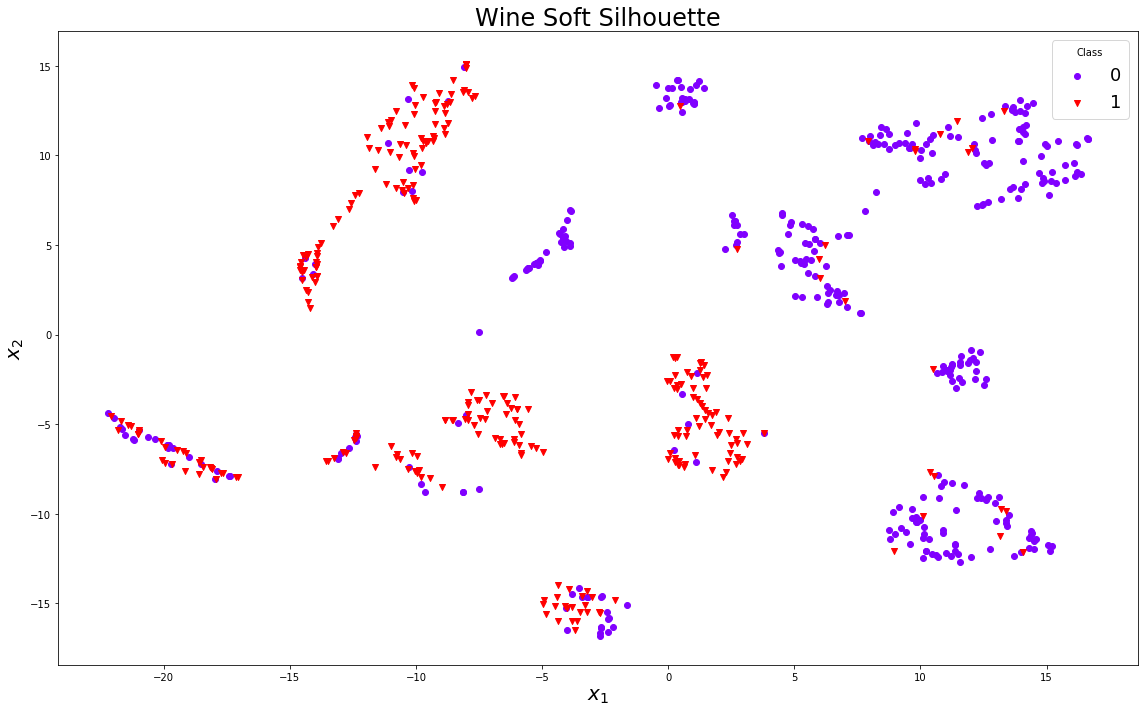

In [7]:
# Cluster with TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_enc = tsne.fit_transform(latent_data)
#tsne_enc = tsne.fit_transform(real_data)

# Color and marker for each true class
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
markers = matplotlib.markers.MarkerStyle.filled_markers

# Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16, 10))
for iclass in range(0, n_clusters):
    # Get indices for each class
    idxs = real_labels==iclass
    # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0], tsne_enc[idxs, 1],
               marker=markers[iclass], c=colors[iclass].reshape(1,-1),
               edgecolor=None, label=r'$%i$'%iclass)
    
figname="Wine Soft Silhouette"
ax.set_title(figname, fontsize=24)
ax.set_xlabel("$x_{1}$", fontsize=20)
ax.set_ylabel("$x_{2}$", fontsize=20)
plt.legend(title="Class", loc='best', numpoints=1, fontsize=18)
plt.tight_layout()
plt.show()
#fig.savefig(figname, facecolor='w')